In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_video
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
############################
# 1. HELPER FUNCTIONS
############################

from video_saccade_detection import detect_saccades_from_video_simple

def find_saccade_indices(video_path, csv_path, fps=60):
    """
    Use the 'detect_saccades_from_video_simple' function 
    to find all saccade start frames for a given video.
    """
    df = pd.read_csv(csv_path)
    stimulus = df["target"].values
    saccade_vector_video_final = detect_saccades_from_video_simple(video_path, stimulus, fps)
    video_saccade_indices = np.arange(len(stimulus))[saccade_vector_video_final == 1]
    return video_saccade_indices

def select_frames(video_tensor, starting_frame, num_frames=16, interval=1, random_offset=False):
    """
    Extract num_frames around 'starting_frame' with optional random offset.
    video_tensor shape: (Frames, H, W, C)
    Returns a sub-tensor of shape (num_frames, H, W, C).
    """
    if random_offset:
        # ±5 frames offset 
        offset = np.random.randint(-5, 6)
        starting_frame += offset
    
    # Basic safe-guard to avoid out-of-range indexing
    start_idx = max(starting_frame - (num_frames // 4)*interval, 0)
    end_idx   = start_idx + num_frames*interval

    # Clip if end_idx goes beyond length
    if end_idx > len(video_tensor):
        end_idx = len(video_tensor)
        start_idx = max(0, end_idx - num_frames*interval)

    return video_tensor[start_idx:end_idx:interval]

In [3]:
############################
# 2. DATASET FOR TRAINING
############################

class SaccadeVideoDataset(Dataset):
    """
    - During training, we randomly pick 1 saccade from the list.
    - During inference, we do NOT want random picking, so typically
      we won't use this dataset for inference; we'll handle inference
      with a separate function that processes all saccades.
    """
    def __init__(self, video_dir, waveform_dir, labels_dict, transform=None, num_frames=32):
        self.video_dir = video_dir
        self.waveform_dir = waveform_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.num_frames = num_frames
        self.video_names = list(labels_dict.keys())  

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_name = self.video_names[idx]
        video_path = os.path.join(self.video_dir, video_name)
        csv_path   = os.path.join(self.waveform_dir, video_name.replace(".mp4", ".csv"))
        label      = self.labels_dict[video_name]

        # Load full video in (T, H, W, C) format
        video_tensor, _, _ = read_video(video_path, pts_unit='sec')

        # Detect all possible saccade starts
        saccade_indices = find_saccade_indices(video_path, csv_path, fps=60)

        # If no saccade found, fallback to random start
        if len(saccade_indices) == 0:
            saccade_frame = np.random.randint(0, max(1, len(video_tensor)))
        else:
            # Randomly pick one
            saccade_frame = np.random.choice(saccade_indices)

        # Select frames around that saccade (with random offset for data augmentation)
        clip = select_frames(video_tensor,
                             starting_frame=saccade_frame,
                             num_frames=self.num_frames,
                             interval=1,
                             random_offset=True) 

        # Permute to (C, T, H, W) and normalize
        clip = clip.permute(3, 0, 1, 2).float() / 255.0  # (C, T, H, W)

        if self.transform:
            clip = self.transform(clip)

        return clip, label

In [4]:
############################
# 3. INFERENCE (ALL SACCADES) FUNCTION
############################

def infer_with_all_saccades(model, video_path, csv_path, transform=None, num_frames=32):
    """
    At inference time, we want to use *all* saccades in the video.
    We'll collect the probability distribution for each saccade, 
    then average them to get a final prediction.
    """
    model.eval()
    video_tensor, _, _ = read_video(video_path, pts_unit='sec')
    
    # Detect all saccades
    saccade_indices = find_saccade_indices(video_path, csv_path, fps=60)
    if len(saccade_indices) == 0:
        # Fallback: produce None or predict from a random snippet
        return None, None
    
    all_probs = []
    with torch.no_grad():
        for saccade_frame in saccade_indices:
            # No random offsets at inference
            clip = select_frames(video_tensor, saccade_frame, num_frames=num_frames, interval=1, random_offset=False)

            # Permute and normalize
            clip = clip.permute(3, 0, 1, 2).float() / 255.0
            if transform:
                clip = transform(clip)

            clip = clip.unsqueeze(0).to(device)  # (1, C, T, H, W)
            logits = model(clip)                 # (1, num_classes)
            probs = F.softmax(logits, dim=1)     # (1, num_classes)
            all_probs.append(probs.cpu().numpy()[0])

    # Average probabilities across all saccades
    avg_probs = np.mean(all_probs, axis=0)
    pred_class = np.argmax(avg_probs)
    return pred_class, avg_probs

In [5]:
############################
# 4. PREPARE DATA
############################

# Adjust these paths to match your environment
VIDEO_DATA_DIR   = '/home/ryujjoo0810/jooyoung2/pcm/videos'
MASK_DATA_DIR    = '/home/ryujjoo0810/jooyoung2/pcm/masks'       
WAVEFORM_DATA_DIR= '/home/ryujjoo0810/jooyoung2/pcm/waveforms'
CSV_FILE         = '/home/ryujjoo0810/jooyoung2/pcm/video_labels.csv'

# Load labels from CSV => { filename: label_id }
labels_df = pd.read_csv(CSV_FILE)

labels_dict = dict(zip(labels_df["filename"], labels_df["label"]))


# Transforms
transform = transforms.Compose([
    transforms.Resize((112, 112)),               # Typical for R(2+1)D
    transforms.Normalize(mean=[0.5], std=[0.5])  # If single channel means, adjust if 3-ch
])

# Build Dataset for TRAINING
full_dataset = SaccadeVideoDataset(
    video_dir=VIDEO_DATA_DIR,
    waveform_dir=WAVEFORM_DATA_DIR,
    labels_dict=labels_dict,
    transform=transform,
    num_frames=32 
)

# Split Train/Test
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, num_workers=4)

Removing fc.weight from checkpoint due to shape mismatch.
Removing fc.bias from checkpoint due to shape mismatch.


Epoch 1/40: 100%|██████████| 74/74 [00:16<00:00,  4.62it/s, loss=1.1445]


Epoch [1/40] - Loss: 1.1380


Epoch 2/40: 100%|██████████| 74/74 [00:16<00:00,  4.55it/s, loss=1.3490]


Epoch [2/40] - Loss: 1.0579


Epoch 3/40: 100%|██████████| 74/74 [00:16<00:00,  4.57it/s, loss=0.9659]


Epoch [3/40] - Loss: 0.9607


Epoch 4/40: 100%|██████████| 74/74 [00:16<00:00,  4.60it/s, loss=1.3674]


Epoch [4/40] - Loss: 0.9106


Epoch 5/40: 100%|██████████| 74/74 [00:16<00:00,  4.60it/s, loss=0.8577]


Epoch [5/40] - Loss: 0.8719


Epoch 6/40: 100%|██████████| 74/74 [00:16<00:00,  4.53it/s, loss=0.8098]


Epoch [6/40] - Loss: 0.8537


Epoch 7/40: 100%|██████████| 74/74 [00:16<00:00,  4.53it/s, loss=0.6232]


Epoch [7/40] - Loss: 0.7230


Epoch 8/40: 100%|██████████| 74/74 [00:16<00:00,  4.47it/s, loss=0.9881]


Epoch [8/40] - Loss: 0.5890


Epoch 9/40: 100%|██████████| 74/74 [00:16<00:00,  4.60it/s, loss=0.6178]


Epoch [9/40] - Loss: 0.6921


Epoch 10/40: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s, loss=0.4575]


Epoch [10/40] - Loss: 0.5530


Epoch 11/40: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s, loss=0.4764]


Epoch [11/40] - Loss: 0.4604


Epoch 12/40: 100%|██████████| 74/74 [00:16<00:00,  4.47it/s, loss=0.3912]


Epoch [12/40] - Loss: 0.3303


Epoch 13/40: 100%|██████████| 74/74 [00:16<00:00,  4.41it/s, loss=0.2774]


Epoch [13/40] - Loss: 0.4019


Epoch 14/40: 100%|██████████| 74/74 [00:16<00:00,  4.39it/s, loss=0.1874]


Epoch [14/40] - Loss: 0.3879


Epoch 15/40: 100%|██████████| 74/74 [00:16<00:00,  4.58it/s, loss=0.3203]


Epoch [15/40] - Loss: 0.3954


Epoch 16/40: 100%|██████████| 74/74 [00:16<00:00,  4.54it/s, loss=0.3039]


Epoch [16/40] - Loss: 0.2851


Epoch 17/40: 100%|██████████| 74/74 [00:16<00:00,  4.56it/s, loss=0.5909]


Epoch [17/40] - Loss: 0.3150


Epoch 18/40: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s, loss=0.8067]


Epoch [18/40] - Loss: 0.2510


Epoch 19/40: 100%|██████████| 74/74 [00:16<00:00,  4.48it/s, loss=0.0718]


Epoch [19/40] - Loss: 0.3189


Epoch 20/40: 100%|██████████| 74/74 [00:16<00:00,  4.50it/s, loss=0.4439]


Epoch [20/40] - Loss: 0.2766


Epoch 21/40: 100%|██████████| 74/74 [00:16<00:00,  4.61it/s, loss=0.0993]


Epoch [21/40] - Loss: 0.2208


Epoch 22/40: 100%|██████████| 74/74 [00:16<00:00,  4.37it/s, loss=0.0513]


Epoch [22/40] - Loss: 0.3218


Epoch 23/40: 100%|██████████| 74/74 [00:16<00:00,  4.53it/s, loss=0.2451]


Epoch [23/40] - Loss: 0.2838


Epoch 24/40: 100%|██████████| 74/74 [00:15<00:00,  4.64it/s, loss=0.3238]


Epoch [24/40] - Loss: 0.3222


Epoch 25/40: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s, loss=0.4099]


Epoch [25/40] - Loss: 0.2633


Epoch 26/40: 100%|██████████| 74/74 [00:16<00:00,  4.53it/s, loss=0.6437]


Epoch [26/40] - Loss: 0.3311


Epoch 27/40: 100%|██████████| 74/74 [00:16<00:00,  4.52it/s, loss=0.2072]


Epoch [27/40] - Loss: 0.2850


Epoch 28/40: 100%|██████████| 74/74 [00:16<00:00,  4.54it/s, loss=0.0647]


Epoch [28/40] - Loss: 0.2521


Epoch 29/40: 100%|██████████| 74/74 [00:16<00:00,  4.55it/s, loss=0.0581]


Epoch [29/40] - Loss: 0.2552


Epoch 30/40: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s, loss=0.2987]


Epoch [30/40] - Loss: 0.2699


Epoch 31/40: 100%|██████████| 74/74 [00:16<00:00,  4.47it/s, loss=0.0642]


Epoch [31/40] - Loss: 0.2408


Epoch 32/40: 100%|██████████| 74/74 [00:16<00:00,  4.42it/s, loss=0.3293]


Epoch [32/40] - Loss: 0.2610


Epoch 33/40: 100%|██████████| 74/74 [00:16<00:00,  4.56it/s, loss=0.2047]


Epoch [33/40] - Loss: 0.2836


Epoch 34/40: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s, loss=0.0789]


Epoch [34/40] - Loss: 0.2720


Epoch 35/40: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s, loss=1.3459]


Epoch [35/40] - Loss: 0.2063


Epoch 36/40: 100%|██████████| 74/74 [00:16<00:00,  4.43it/s, loss=0.1075]


Epoch [36/40] - Loss: 0.2408


Epoch 37/40: 100%|██████████| 74/74 [00:16<00:00,  4.45it/s, loss=0.3507]


Epoch [37/40] - Loss: 0.2007


Epoch 38/40: 100%|██████████| 74/74 [00:16<00:00,  4.44it/s, loss=0.1194]


Epoch [38/40] - Loss: 0.3006


Epoch 39/40: 100%|██████████| 74/74 [00:16<00:00,  4.54it/s, loss=0.0657]


Epoch [39/40] - Loss: 0.2912


Epoch 40/40: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s, loss=0.0840]


Epoch [40/40] - Loss: 0.2654


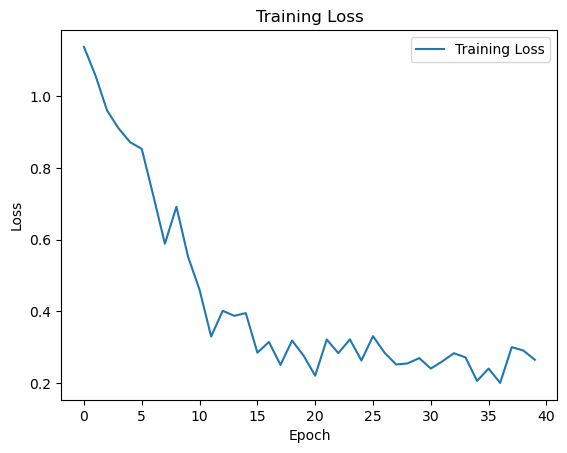

In [6]:
############################
# 5. MODEL DEFINITION + TRAINING
############################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# R(2+1)D loaded from offline weights
def load_model_offline(model_name, pth_path, ignore_key):
    model = model_name(weights=None, num_classes=3)
    state_dict = torch.load(pth_path, map_location='cpu')
    # Remove parameters from the head if they exist in the state dict
    for key in list(state_dict.keys()):
        if key.startswith(ignore_key):
            print(f"Removing {key} from checkpoint due to shape mismatch.")
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    return model

model = load_model_offline(
    r2plus1d_18,
    "./pretrained_weights/r2plus1d_18-91a641e6.pth",
    ignore_key="fc"
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# LR Scheduler: drop by 10× every 10 epochs
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 40  
training_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for (inputs, labels) in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    pbar.close()
    scheduler.step() 
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [7]:
############################
# 6. EVALUATION ON TEST SET (ALL SACCADES)
############################

model.eval()

test_indices = test_dataset.indices  # The actual indices in the original dataset
all_labels = []
all_preds = []
all_probs = []

for idx in tqdm(test_indices, desc="Inference (All Saccades)"):
    video_name = full_dataset.video_names[idx]
    true_label = full_dataset.labels_dict[video_name]  # numeric e.g. 0,1,2
    csv_path   = os.path.join(WAVEFORM_DATA_DIR, video_name.replace(".mp4", ".csv"))
    video_path = os.path.join(VIDEO_DATA_DIR, video_name)

    pred_class, avg_probs = infer_with_all_saccades(
        model=model,
        video_path=video_path,
        csv_path=csv_path,
        transform=transform,
        num_frames=32
    )
    # If None => no saccade found, skip or handle fallback
    if pred_class is None or avg_probs is None:
        continue

    all_labels.append(true_label)
    all_preds.append(pred_class)
    all_probs.append(avg_probs)

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

Inference (All Saccades): 100%|██████████| 75/75 [00:15<00:00,  4.78it/s]


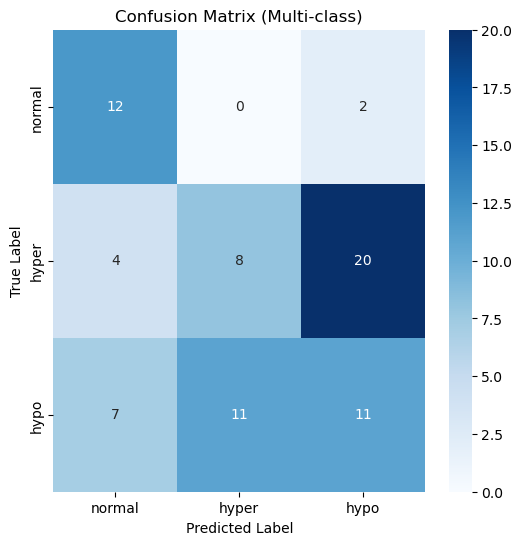

              precision    recall  f1-score   support

      normal       0.52      0.86      0.65        14
       hyper       0.42      0.25      0.31        32
        hypo       0.33      0.38      0.35        29

    accuracy                           0.41        75
   macro avg       0.43      0.50      0.44        75
weighted avg       0.41      0.41      0.39        75

Class normal - AUROC: 0.9391, AUPRC: 0.7919
Class hyper - AUROC: 0.5283, AUPRC: 0.4749
Class hypo - AUROC: 0.4378, AUPRC: 0.3334


In [8]:
############################
# 7. MULTI-CLASS EVALUATION
############################

# 7a. Multi-class Confusion Matrix
class_names = ['normal', 'hyper', 'hypo']  # match your numeric labels {0,1,2}
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Multi-class)")
plt.show()

# 7b. Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# 7c. AUROC / AUPRC per class (optional)
for i, cls_name in enumerate(class_names):
    y_true = (all_labels == i).astype(int)
    y_score = all_probs[:, i]
    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)
    print(f"Class {cls_name} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

In [9]:
############################
# 8. BINARY METRICS (Sensitivity, Specificity, PPV)
############################

# Treat normal as NEGATIVE, and hyper/hypo as POSITIVE.
# mapped normal=0 => 0, hyper=1 => 1, hypo=2 => 1
def to_binary_label(class_id):
    if class_id == 0:  # normal
        return 0
    else:  # hyper or hypo
        return 1

bin_true = [to_binary_label(lbl) for lbl in all_labels]
bin_pred = [to_binary_label(prd) for prd in all_preds]

tn, fp, fn, tp = confusion_matrix(bin_true, bin_pred, labels=[0,1]).ravel()
sensitivity = tp / (tp + fn)    # TPR
specificity = tn / (tn + fp)    # TNR
ppv         = tp / (tp + fp)    # Precision

print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV:         {ppv:.3f}")

Sensitivity: 0.820
Specificity: 0.857
PPV:         0.962


In [10]:
import os
import pandas as pd

############################
# 9. SAVE MODEL & RESULTS
############################

# 1️⃣ Save Model Weights
model_save_path = "inference_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# 2️⃣ Save Predictions & Labels
results_df = pd.DataFrame({
    "video_filename": [full_dataset.video_names[idx] for idx in test_indices],  # Video names
    "true_label": all_labels,  # True class labels
    "predicted_label": all_preds,  # Predicted labels
    "predicted_probabilities": list(all_probs)  # List of full probability distributions
})

results_csv_path = "inference_model_predictions.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Predictions saved to: {results_csv_path}")


Model saved to: inference_model.pth
Predictions saved to: inference_model_predictions.csv
